(500, 500, 3)


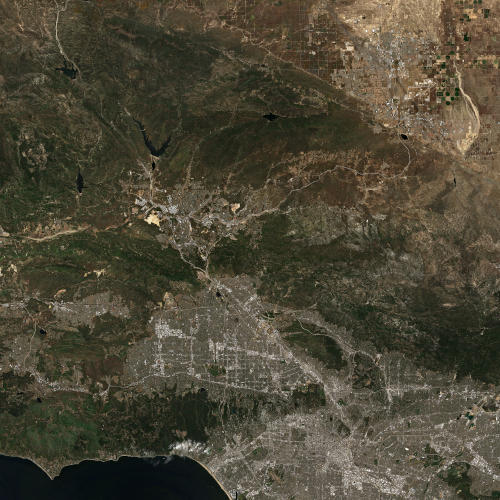

In [1]:
%matplotlib notebook
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("data.png")
data = np.array(image)[:, :, :3].astype(np.float) / 255
print(data.shape)
image

In [2]:
from PIL import Image
import numpy
import math
import random


# Class

class Pixel:
    """class Pixel"""
    def __init__(self, initX: int, initY: int, initColor):
        self.x = initX
        self.y = initY
        self.color = initColor
        
class Cluster:
    """Cluster in Gray"""
    def __init__(self, initCenter):
        self.center = initCenter
        self.pixelList = []

class ClusterPair:
    """Cluster Pair"""
    def __init__(self, initClusterAIndex: int, initClusterBIndex: int, initDistance):
        self.clusterAIndex = initClusterAIndex
        self.clusterBIndex = initClusterBIndex
        self.distance = initDistance



def distanceBetweenE(colorA, colorB) -> float:
    """weighted Euclidean distance"""
    aveR = float(int(colorA[0]) + int(colorB[0])) / 2
    dR = int(colorA[0]) - int(colorB[0])
    dG = int(colorA[1]) - int(colorB[1])
    dB = int(colorA[2]) - int(colorB[2])
    return math.sqrt((2 + aveR / 256) * (dR ** 2) + 4 * (dG ** 2) + (2 + (255 - aveR) / 256) * (dB ** 2))
    
def distanceBetween(colorA, colorB) -> float:
    """Euclidaian distance """
    dR = int(colorA[0]) - int(colorB[0])
    dG = int(colorA[1]) - int(colorB[1])
    dB = int(colorA[2]) - int(colorB[2])
    return math.sqrt(dR ** 2 + dG ** 2 +dB ** 2)


def ISODATARGB(image, K: int, TN: int, TS: float, TC:int, L: int, I: int) -> Image.Image:
    """       ISODATA Algorithm
    
    - The distance implemented here is the Euclidian distance :distanceBetween
    - To use a weighted Euclidean distance change distanceBetween by distanceBetweenE
    
    """
    imgArray = numpy.array(image)
    imgY, imgX = image.size
    clusterList = []
    # Generate K cluster centers randomly
    for i in range(0, K):
        randomX = random.randint(0, imgX - 1)
        randomY = random.randint(0, imgY - 1)
        duplicated = False
        for cluster in clusterList:
            if (cluster.center[0] == imgArray[randomX, randomY, 0] and
                cluster.center[1] == imgArray[randomX, randomY, 1] and
                cluster.center[2] == imgArray[randomX, randomY, 2]):
                duplicated = True
                break
        if not duplicated:
            clusterList.append(Cluster(numpy.array([imgArray[randomX, randomY, 0],
                                                    imgArray[randomX, randomY, 1],
                                                    imgArray[randomX, randomY, 2]],
                                                    dtype = numpy.uint8)))

    # Iteration
    iterationCount = 0
    didAnythingInLastIteration = True
    while True:
        iterationCount += 1

        # Clear the pixel lists of all clusters
        for cluster in clusterList:
            cluster.pixelList.clear()
        print("------")
        print("Iteration: {0}".format(iterationCount))

        # Classify all pixels into clusters
        print("Classifying...", end = '', flush = True)
        for row in range(0, imgX):
            for col in range(0, imgY):
                targetClusterIndex = 0
                targetClusterDistance = distanceBetween(imgArray[row, col], clusterList[0].center)
                # Classify
                for i in range(1, len(clusterList)):
                    currentDistance = distanceBetween(imgArray[row, col], clusterList[i].center)
                    if currentDistance < targetClusterDistance:
                        targetClusterDistance = currentDistance
                        targetClusterIndex = i
                clusterList[targetClusterIndex].pixelList.append(Pixel(row, col, imgArray[row, col]))
        print(" Finished.")

        # Check Mininum of sample in one cluster
        gotoNextIteration = False
        for i in range(len(clusterList) - 1, -1, -1):
            if len(clusterList[i].pixelList) < TN:
                # Re-classify
                clusterList.pop(i)
                gotoNextIteration = True
                break
        if gotoNextIteration:
            print("Nmin checking not passed.")
            continue
        print("Nmin checking passed.")

        # Recalculate the centers
        print("Recalculating the centers...", end = '', flush = True)
        for cluster in clusterList:
            sumR = 0.0
            sumG = 0.0
            sumB = 0.0
            for pixel in cluster.pixelList:
                sumR += int(pixel.color[0])
                sumG += int(pixel.color[1])
                sumB += int(pixel.color[2])
            aveR = round(sumR / len(cluster.pixelList))
            aveG = round(sumG / len(cluster.pixelList))
            aveB = round(sumB / len(cluster.pixelList))
            if (aveR != cluster.center[0] and
                aveG != cluster.center[1] and
                aveB != cluster.center[2]):
                didAnythingInLastIteration = True
            cluster.center = numpy.array([aveR, aveG, aveB], dtype = numpy.uint8)
        print(" Finished.")
        if iterationCount > I:
            break
        if not didAnythingInLastIteration:
            print("More iteration is not necessary.")
            break

        # Calculate the average distance
        print("Preparing for Merging and Spliting...", end = '', flush = True)
        aveDisctanceList = []
        sumDistanceAll = 0.0
        for cluster in clusterList:
            currentSumDistance = 0.0
            for pixel in cluster.pixelList:
                currentSumDistance += distanceBetween(pixel.color, cluster.center)
            aveDisctanceList.append(float(currentSumDistance) / len(cluster.pixelList))
            sumDistanceAll += currentSumDistance
        aveDistanceAll = float(sumDistanceAll) / (imgX * imgY)
        print(" Finished.")

        if (len(clusterList) <= K / 2) or not (iterationCount % 2 == 0 or len(clusterList) >= K * 2):
            # Split
            print("Split:", end = '', flush = True)
            beforeCount = len(clusterList)
            for i in range(len(clusterList) - 1, -1, -1):
                currentSD = [0.0, 0.0, 0.0]
                for pixel in clusterList[i].pixelList:
                    currentSD[0] += (int(pixel.color[0]) - int(clusterList[i].center[0])) ** 2
                    currentSD[1] += (int(pixel.color[1]) - int(clusterList[i].center[1])) ** 2
                    currentSD[2] += (int(pixel.color[2]) - int(clusterList[i].center[2])) ** 2
                currentSD[0] = math.sqrt(currentSD[0] / len(clusterList[i].pixelList))
                currentSD[1] = math.sqrt(currentSD[1] / len(clusterList[i].pixelList))
                currentSD[2] = math.sqrt(currentSD[2] / len(clusterList[i].pixelList))
                # Find the max in SD of R, G and B
                maxSD = currentSD[0]
                for j in (1, 2):
                    maxSD = currentSD[j] if currentSD[j] > maxSD else maxSD
                if (maxSD > TS) and ((aveDisctanceList[i] > aveDistanceAll and len(clusterList[i].pixelList) > 2 * (TN + 1)) or (len(clusterList) < K / 2)):
                    gamma = 0.5 * maxSD
                    clusterList[i].center[0] += gamma
                    clusterList[i].center[1] += gamma
                    clusterList[i].center[2] += gamma
                    clusterList.append(Cluster(numpy.array([clusterList[i].center[0],
                                                            clusterList[i].center[1],
                                                            clusterList[i].center[2]],
                                                            dtype = numpy.uint8)))
                    clusterList[i].center[0] -= gamma * 2
                    clusterList[i].center[1] -= gamma * 2
                    clusterList[i].center[2] -= gamma * 2
                    clusterList.append(Cluster(numpy.array([clusterList[i].center[0],
                                                            clusterList[i].center[1],
                                                            clusterList[i].center[2]],
                                                            dtype = numpy.uint8)))
                    clusterList.pop(i)
            print(" {0} -> {1}".format(beforeCount, len(clusterList)))
        elif (iterationCount % 2 == 0) or (len(clusterList) >= K * 2) or (iterationCount == I):
            # Merge
            print("Merge:", end = '', flush = True)
            beforeCount = len(clusterList)
            didAnythingInLastIteration = False
            clusterPairList = []
            for i in range(0, len(clusterList)):
                for j in range(0, i):
                    currentDistance = distanceBetween(clusterList[i].center, clusterList[j].center)
                    if currentDistance < TC:
                        clusterPairList.append(ClusterPair(i, j, currentDistance))

            clusterPairListSorted = sorted(clusterPairList, key = lambda clusterPair: clusterPair.distance)
            newClusterCenterList = []
            mergedClusterIndexList = []
            mergedPairCount = 0
            for clusterPair in clusterPairList:
                hasBeenMerged = False
                for index in mergedClusterIndexList:
                    if clusterPair.clusterAIndex == index or clusterPair.clusterBIndex == index:
                        hasBeenMerged = True
                        break
                if hasBeenMerged:
                    continue
                newCenterR = int((len(clusterList[clusterPair.clusterAIndex].pixelList) * float(clusterList[clusterPair.clusterAIndex].center[0]) + len(clusterList[clusterPair.clusterBIndex].pixelList) * float(clusterList[clusterPair.clusterBIndex].center[0])) / (len(clusterList[clusterPair.clusterAIndex].pixelList) + len(clusterList[clusterPair.clusterBIndex].pixelList)))
                newCenterG = int((len(clusterList[clusterPair.clusterAIndex].pixelList) * float(clusterList[clusterPair.clusterAIndex].center[1]) + len(clusterList[clusterPair.clusterBIndex].pixelList) * float(clusterList[clusterPair.clusterBIndex].center[1])) / (len(clusterList[clusterPair.clusterAIndex].pixelList) + len(clusterList[clusterPair.clusterBIndex].pixelList)))
                newCenterB = int((len(clusterList[clusterPair.clusterAIndex].pixelList) * float(clusterList[clusterPair.clusterAIndex].center[2]) + len(clusterList[clusterPair.clusterBIndex].pixelList) * float(clusterList[clusterPair.clusterBIndex].center[2])) / (len(clusterList[clusterPair.clusterAIndex].pixelList) + len(clusterList[clusterPair.clusterBIndex].pixelList)))
                newClusterCenterList.append([newCenterR, newCenterG, newCenterB])
                mergedClusterIndexList.append(clusterPair.clusterAIndex)
                mergedClusterIndexList.append(clusterPair.clusterBIndex)
                mergedPairCount += 1
                if mergedPairCount > L:
                    break
            if len(mergedClusterIndexList) > 0:
                didAnythingInLastIteration = True
            mergedClusterIndexListSorted = sorted(mergedClusterIndexList, key = lambda clusterIndex: clusterIndex, reverse = True)
            for index in mergedClusterIndexListSorted:
                clusterList.pop(index)
            for center in newClusterCenterList:
                clusterList.append(Cluster(numpy.array([center[0], center[1], center[2]], dtype = numpy.uint8)))
            print(" {0} -> {1}".format(beforeCount, len(clusterList)))

    # Generate the new image martrix
    print("Over")
    print("Classified to {0} kinds.".format(len(clusterList)))
    newImgArray = numpy.zeros((imgX, imgY, 3), dtype = numpy.uint8)
    for cluster in clusterList:
        for pixel in cluster.pixelList:
            newImgArray[pixel.x, pixel.y, 0] = int(cluster.center[0])
            newImgArray[pixel.x, pixel.y, 1] = int(cluster.center[1])
            newImgArray[pixel.x, pixel.y, 2] = int(cluster.center[2])

    return Image.fromarray(newImgArray, mode = "RGB")


------
Iteration: 1
Classifying... Finished.
Nmin checking passed.
Recalculating the centers... Finished.
Preparing for Merging and Spliting... Finished.
Split: 3 -> 4
------
Iteration: 2
Classifying... Finished.
Nmin checking passed.
Recalculating the centers... Finished.
Preparing for Merging and Spliting... Finished.
Merge: 4 -> 3
------
Iteration: 3
Classifying... Finished.
Nmin checking passed.
Recalculating the centers... Finished.
Preparing for Merging and Spliting... Finished.
Split: 3 -> 4
------
Iteration: 4
Classifying... Finished.
Nmin checking passed.
Recalculating the centers... Finished.
Preparing for Merging and Spliting... Finished.
Merge: 4 -> 4
------
Iteration: 5
Classifying... Finished.
Nmin checking passed.
Recalculating the centers... Finished.
Preparing for Merging and Spliting... Finished.
Split: 4 -> 6
------
Iteration: 6
Classifying... Finished.
Nmin checking passed.
Recalculating the centers... Finished.
Preparing for Merging and Spliting... Finished.
Merge:

<IPython.core.display.Javascript object>


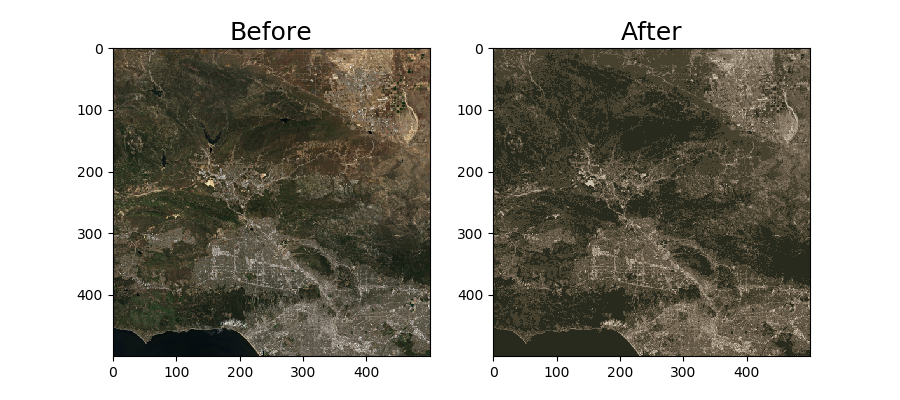

In [3]:
# Modules
import sys, getopt, time
from PIL import Image
import numpy
import matplotlib.pyplot as plot



if __name__ == '__main__':
    image = Image.open('data.png')
    Kinit = 3          #The number of expected clusters
    Nmin= 3            #Mininum of sample in one cluster
    Stdmax = 4.0       #Standard deviation
    Lmin = 40          #Mininum of distance between two clusters
    Pmax = 10          #Maxinum of merging during every iteration
    Imax = 9           #Maxinum of iteration 
    result = ISODATARGB(image, Kinit, Nmin, Stdmax, Lmin, Pmax, Imax)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    #plt.subplot(1, 2, 1)
    ax1.set_title('Before',fontsize=18, ha='center')
    ax1.imshow(image, interpolation='nearest',aspect="auto")
    #plt.subplot(1, 2, 2)
    ax2.set_title('After',fontsize=18, ha='center')
    ax2.imshow(result,aspect="auto")
    plot.show()

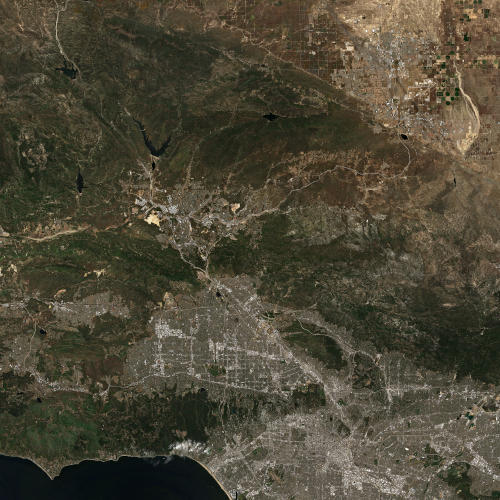

In [4]:
image

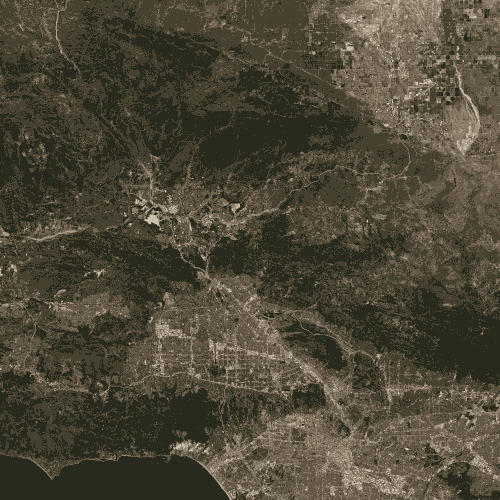

In [5]:
result